# Thử nghiệm Label Propagation & Label Spreading

**Mục tiêu:**
Notebook này thực hiện thử nghiệm với hai thuật toán semi-supervised learning dựa trên đồ thị (graph-based) là `LabelPropagation` và `LabelSpreading`.

**Các bước thực hiện:**
1.  **Cấu hình thử nghiệm**: Định nghĩa các tham số khác nhau cho hai mô hình, bao gồm `kernel`, `gamma` (cho RBF kernel), và `n_neighbors` (cho KNN kernel).
2.  **Chuẩn bị dữ liệu**: Tải và lấy một **mẫu nhỏ (10%)** từ bộ dữ liệu semi-supervised để chạy thử nghiệm nhanh.
3.  **Chạy thử nghiệm**: Huấn luyện từng mô hình với các cấu hình đã định và đánh giá hiệu năng trên tập test.
4.  **Tổng hợp và Trực quan hóa**: So sánh kết quả F1-macro của các cấu hình để tìm ra phương pháp và tham số tốt nhất trong phạm vi thử nghiệm.
5.  **Phân tích**: Để lại không gian để phân tích ưu/nhược điểm của các phương pháp graph-based so với Self-Training và Co-Training.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# -------- 1. Cấu hình thử nghiệm --------
PROJECT_ROOT = Path(".").resolve().parent
print(f"Project Root: {PROJECT_ROOT}")

# --- Tham số để sweep ---
EXPERIMENT_CONFIGS = {
    "LabelPropagation-KNN": {
        "model": LabelPropagation(kernel='knn', n_neighbors=7),
        "color": "#1F62FF" # Xanh nước biển
    },
    "LabelSpreading-KNN": {
        "model": LabelSpreading(kernel='knn', n_neighbors=7, alpha=0.8),
        "color": "#1FD2FF" # Xanh nhạt
    },
    "LabelPropagation-RBF": {
        "model": LabelPropagation(kernel='rbf', gamma=10),
        "color": "#FF9A1F" # Cam
    },
    "LabelSpreading-RBF": {
        "model": LabelSpreading(kernel='rbf', gamma=10, alpha=0.8),
        "color": "#FFDA1F" # Vàng
    },
}

# --- Cấu hình biểu đồ ---
IMAGES_DIR = PROJECT_ROOT / "images"
IMAGES_DIR.mkdir(exist_ok=True)
FONT_CONFIG = {'fontname': 'Arial', 'fontsize': 11}

Project Root: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard


In [6]:
# -------- 2. Tải và chuẩn bị dữ liệu (Sample) --------
print("Loading and preparing data...")
semi_dataset_path = PROJECT_ROOT / "data" / "processed" / "02_dataset_for_semi.parquet"
df_semi = pd.read_parquet(semi_dataset_path)

# Lấy mẫu nhỏ để chạy nhanh
df_sample = df_semi.sample(frac=0.01, random_state=42)
print(f"Using a sample of {len(df_sample)} rows.")

# --- Preprocessing ---
# Chuyển đổi sang bài toán nhị phân: Healthy vs Unhealthy
# Healthy: Good, Moderate
# Unhealthy: Unhealthy_for_Sensitive_Groups, Unhealthy, Very_Unhealthy, Hazardous
def map_to_binary(aqi_class):
    if pd.isna(aqi_class):
        return np.nan
    if aqi_class in ['Good', 'Moderate']:
        return 'Healthy'
    else:
        return 'Unhealthy'

df_sample['binary_target'] = df_sample['aqi_class'].apply(map_to_binary)

# Loại bỏ các dòng unlabeled không có binary_target
df_sample = df_sample[df_sample['binary_target'].notna()].copy()
print(f"After filtering labeled data: {len(df_sample)} rows.")
print(f"Binary target distribution:\n{df_sample['binary_target'].value_counts()}")

# Encode target
target_encoder = OrdinalEncoder(categories=[['Healthy', 'Unhealthy']])
df_sample['target_encoded'] = target_encoder.fit_transform(df_sample[['binary_target']])

# Features
feature_list_path = PROJECT_ROOT / "data" / "processed" / "03_feature_list.csv"
df_features = pd.read_csv(feature_list_path)
numeric_features = [f for f in df_features["feature"] if f not in ['wd', 'station']]

# Tách labeled và unlabeled (trong trường hợp này tất cả đã là labeled sau khi filter)
# Nhưng để phù hợp với semi-supervised, ta sẽ giả lập lại unlabeled data
df_labeled = df_sample[df_sample['is_labeled']].copy()
df_unlabeled = df_sample[~df_sample['is_labeled']].copy()

print(f"Labeled: {len(df_labeled)}, Unlabeled: {len(df_unlabeled)}")

# Nếu không có unlabeled, cần điều chỉnh chiến lược
if len(df_unlabeled) == 0:
    print("⚠️ No unlabeled data in this sample. Using only labeled data for demonstration.")
    # Tách train/test từ labeled data
    X_train_lab, X_test, y_train_lab, y_test = train_test_split(
        df_labeled[numeric_features],
        df_labeled['target_encoded'],
        test_size=0.3, 
        random_state=42
    )
    
    # Không có unlabeled data
    X_train_full = X_train_lab
    y_train_full = y_train_lab.values
else:
    # Tách train/test từ phần labeled
    X_train_lab, X_test, y_train_lab, y_test = train_test_split(
        df_labeled[numeric_features],
        df_labeled['target_encoded'],
        test_size=0.3, 
        random_state=42
    )
    
    # Chuẩn bị dữ liệu cho semi-supervised model
    # Ma trận X bao gồm: train (labeled) + unlabeled
    X_train_unlab = df_unlabeled[numeric_features]
    X_train_full = pd.concat([X_train_lab, X_train_unlab], axis=0)
    
    # Ma trận y: gán -1 cho các mẫu unlabeled
    y_unlabeled = np.full(X_train_unlab.shape[0], -1)
    y_train_full = np.concatenate([y_train_lab, y_unlabeled])

# Xử lý missing values bằng SimpleImputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_full_imputed = imputer.fit_transform(X_train_full)
X_test_imputed = imputer.transform(X_test)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print(f"Train data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")
print(f"Missing values in train: {pd.DataFrame(X_train_scaled).isna().sum().sum()}")

Loading and preparing data...
Using a sample of 4208 rows.
After filtering labeled data: 374 rows.
Binary target distribution:
binary_target
Unhealthy    261
Healthy      113
Name: count, dtype: int64
Labeled: 374, Unlabeled: 0
⚠️ No unlabeled data in this sample. Using only labeled data for demonstration.
Train data shape: (261, 49)
Test data shape: (113, 49)
Missing values in train: 0


In [7]:
# -------- 3. Chạy thử nghiệm --------
results = []

for name, config in EXPERIMENT_CONFIGS.items():
    print(f"--- Running: {name} ---")
    model = config['model']
    
    # Huấn luyện mô hình
    model.fit(X_train_scaled, y_train_full)
    
    # Dự đoán trên tập test
    y_pred = model.predict(X_test_scaled)
    
    # Tính toán metrics
    f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    
    results.append({
        "model_name": name,
        "f1_macro": f1,
        "accuracy": acc,
        "color": config['color']
    })
    print(f"    F1-macro: {f1:.4f}, Accuracy: {acc:.4f}")

print("\n🎉 All graph-based experiments are complete!")

--- Running: LabelPropagation-KNN ---
    F1-macro: 0.7277, Accuracy: 0.7876
--- Running: LabelSpreading-KNN ---
    F1-macro: 0.7412, Accuracy: 0.8142
--- Running: LabelPropagation-RBF ---
    F1-macro: 0.6896, Accuracy: 0.7345
--- Running: LabelSpreading-RBF ---
    F1-macro: 0.6896, Accuracy: 0.7345

🎉 All graph-based experiments are complete!


Experiment Results:


,model_name,f1_macro,accuracy
1,LabelSpreading-KNN,0.741193,0.814159
0,LabelPropagation-KNN,0.727711,0.787611
2,LabelPropagation-RBF,0.689560,0.734513
3,LabelSpreading-RBF,0.689560,0.734513



Chart saved to: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\12_01_graph_based_comparison.png


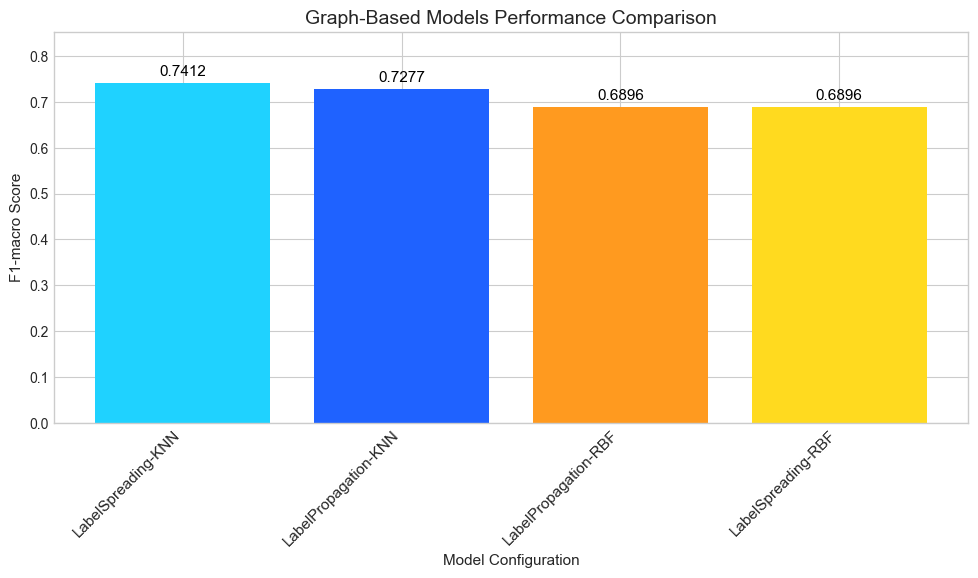

In [8]:
# -------- 4. Tổng hợp & Trực quan hóa --------
if results:
    df_results = pd.DataFrame(results).sort_values("f1_macro", ascending=False)

    # --- Hiển thị bảng kết quả ---
    print("Experiment Results:")
    display(df_results[['model_name', 'f1_macro', 'accuracy']])

    # --- Vẽ biểu đồ so sánh ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    # Tạo biểu đồ cột
    bars = ax.bar(df_results['model_name'], df_results['f1_macro'], color=df_results['color'])

    # Thêm text giá trị trên cột
    ax.bar_label(bars, fmt='%.4f', color='black', fontsize=11, padding=3)

    # Định dạng
    ax.set_xlabel('Model Configuration', **FONT_CONFIG)
    ax.set_ylabel('F1-macro Score', **FONT_CONFIG)
    title_font_config = FONT_CONFIG.copy()
    title_font_config['fontsize'] = 14
    ax.set_title('Graph-Based Models Performance Comparison', **title_font_config)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', **FONT_CONFIG)
    ax.set_ylim(0, df_results['f1_macro'].max() * 1.15)

    plt.tight_layout(pad=1.5)

    # Lưu biểu đồ
    save_path = IMAGES_DIR / "12_01_graph_based_comparison.png"
    plt.savefig(save_path, dpi=300)
    print(f"\nChart saved to: {save_path}")

    plt.show()
else:
    print("No results to display.")